In [1]:
import pyximport
pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
from gammapy.maps import Map
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    GaussianSpatialModel,
    Models,
    FoVBackgroundModel,
)
import sys
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [2]:
figformat = 'png'

In [3]:
ampli = Parameter("amplitude", value = 1e-12)
dataset_asimov_cl = Dataset_load.create_asimov(source = "PKSflare", model = 'pl', parameters = Parameters([ampli]))
point_spatial_model = dataset_asimov_cl.models[0].spatial_model

gaussian_spatial_model = GaussianSpatialModel(lon_0 = point_spatial_model.lon_0,
                                             lat_0 = point_spatial_model.lat_0,
                                             sigma = 0.5*u.deg)
model = SkyModel(spatial_model = gaussian_spatial_model.copy(),
                 spectral_model= dataset_asimov_cl.models[0].spectral_model.copy(),
                 name = "source")
dataset_asimov_cl.models = Models([model.copy(), dataset_asimov_cl.background_model])
dataset_asimov_cl.counts = dataset_asimov_cl.npred()

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz


<WCSAxes: >

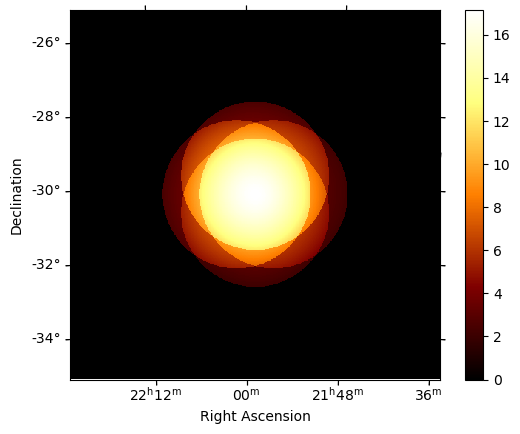

In [4]:
dataset_asimov_cl.counts.sum_over_axes().plot(add_cbar =1)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 106
	total stat : 851228.65

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: user 16.7 s, sys: 3.38 s, total: 20.1 s
Wall time: 20.1 s


<Axes: >

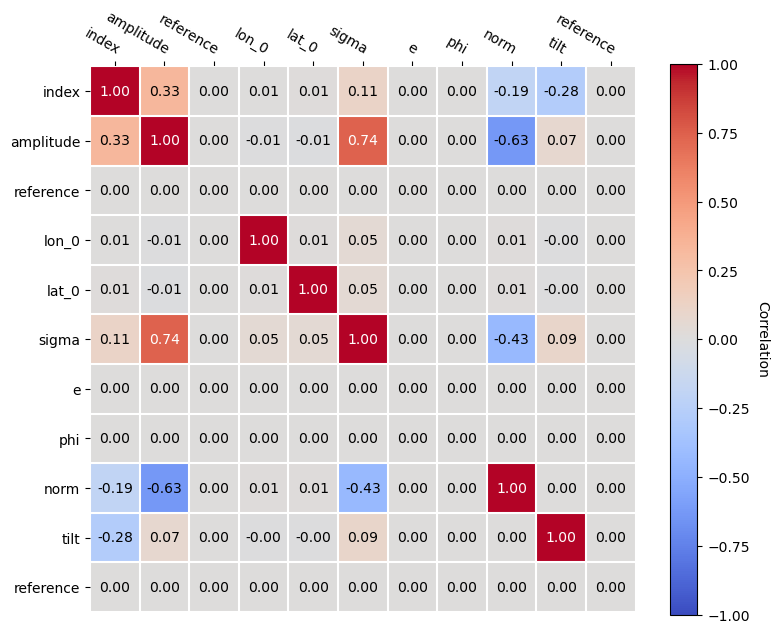

In [5]:
%%time
fit_cl = Fit()
result_cl= fit_cl.run(dataset_asimov_cl)
print(result_cl)
dataset_asimov_cl.models.covariance = fit_cl.covariance(dataset_asimov_cl).matrix
dataset_asimov_cl.models.covariance.plot_correlation()

In [6]:
print(dataset_asimov_cl.models.parameters.to_table())

  type      name      value         unit        error      min        max     frozen is_norm is_penalised link
-------- --------- ----------- -------------- --------- ---------- ---------- ------ ------- ------------ ----
spectral     index  2.3000e+00                2.175e-01        nan        nan  False   False        False     
spectral amplitude  1.0000e-12 cm-2 s-1 TeV-1 5.039e-13        nan        nan  False    True        False     
spectral reference  1.0000e+00            TeV 0.000e+00        nan        nan   True   False        False     
 spatial     lon_0  3.2968e+02            deg 2.349e-01  3.287e+02  3.307e+02  False   False        False     
 spatial     lat_0 -3.0222e+01            deg 2.018e-01 -3.122e+01 -2.922e+01  False   False        False     
 spatial     sigma  5.0000e-01            deg 1.500e-01  0.000e+00        nan  False   False        False     
 spatial         e  0.0000e+00                0.000e+00  0.000e+00  1.000e+00   True   False        False     
 

In [7]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    
    return ax

def plot_par_one(par1,x,  label,ax, fmt ='x', markersize = 6):
    ax.errorbar(x = x, y = par1.value, yerr = par1.error, fmt= fmt,
                markersize = markersize,
                label = label,
               alpha = 0.7)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            try:
                plot_par(m.parameters[p[0]],
                 m.parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                        fmt = fmts[j],
                        markersize = markersize[j])
            except:
                pass

    plt.tight_layout()
    ax[0].legend()
    
def plot_source_par_one(model_name, pars):
    fig, ax = plt.subplots(4,int(len(pars)/3), figsize = (6, 9))
    ax= ax.flatten()
    xx = [0]*len(pars)
    x2 = [0,0.5]    
    for i, p in enumerate(pars):
        for j, m in enumerate (models_list):
            try:
            
                plot_par_one(m.parameters[p],
                         x = xx[i]+ x2[j],
                    label= labels[j],
                    ax = ax[i],
                    fmt = fmts[j],
                    markersize = markersize[j])
                ax[i].hlines(dataset_input.models.parameters[p].value, -0.5, 1.)
            except:
                pass

    plt.tight_layout()
    ax[i].legend()
    for a in ax:
        a.set_xlim(-0.5,1)

labels = ['with PSF nuis' , 'st']
fmts = ['o','x', '*'] * 3
markersize = [6,10, 11] * 3

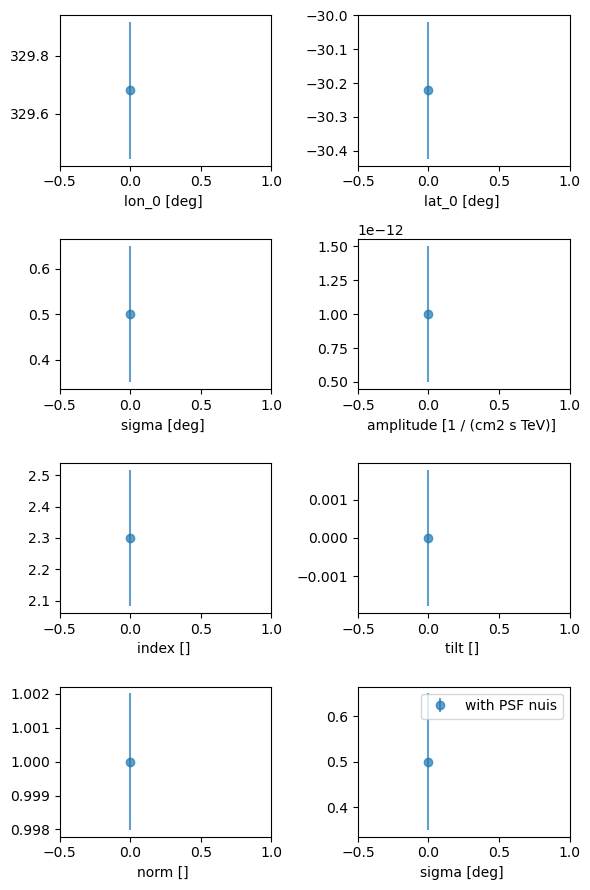

In [8]:
models_list = [dataset_asimov_cl.models ]

pars =  pars = ['lon_0', 'lat_0' , 'sigma', 'amplitude', 'index','tilt', 'norm', 'sigma']
plot_source_par_one(0, pars)


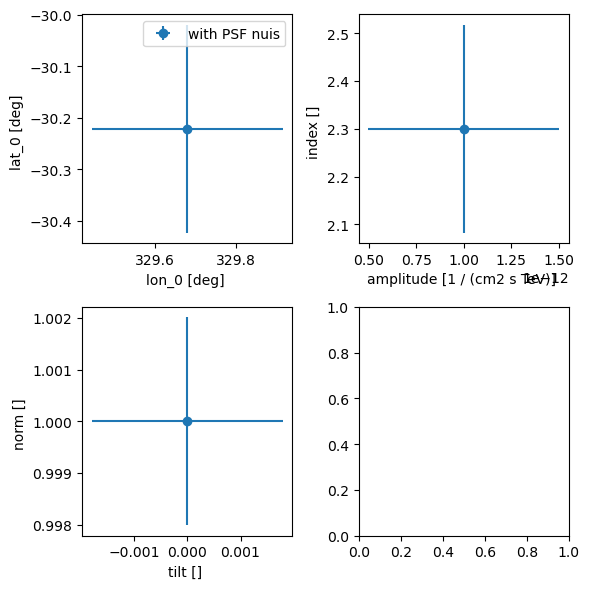

In [9]:
models_list = [dataset_asimov_cl.models ]

pars =  pars = [('lon_0', 'lat_0'),('amplitude', 'index'), ('tilt', 'norm')]
plot_source_par(0, pars)


In [10]:
dataset_asimov_cl.models[0]

SkyModel(spatial_model=<gammapy.modeling.models.spatial.GaussianSpatialModel object at 0x7f33b8ba7af0>, spectral_model=<gammapy.modeling.models.spectral.PowerLawSpectralModel object at 0x7f33b8ba7e20>)temporal_model=None)

<Axes: >

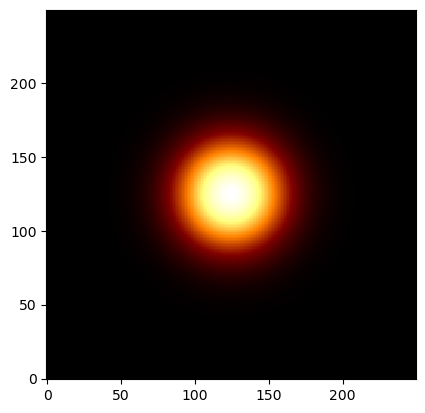

In [11]:
fig,ax = plt.subplots(1,1)
dataset_asimov_cl.models[0].spatial_model.plot(ax = ax)

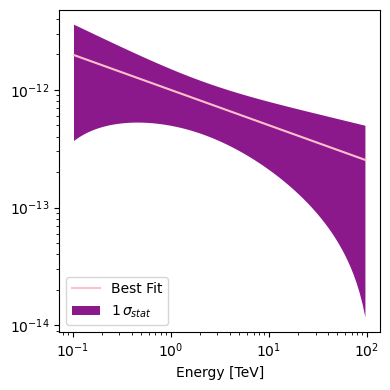

In [12]:


fig,axs = plt.subplots(1,1, sharey=True,figsize = (4,4))
axs = [ axs]

energy_bounds = [0.1,100]*u.TeV
ax = axs[0]

dataset_asimov_cl.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Best Fit", color = 'pink')
dataset_asimov_cl.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax =ax,
                                                       facecolor='purple',
                                                          alpha = 0.9,
                                                          label= "1$\,\sigma_{stat}$"
                                                         )
axs[0].legend(loc='lower left')
#axs[0].set_ylim(5e-14,3e-12) 
axs[0].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()


(<WCSAxes: >, <Axes: xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

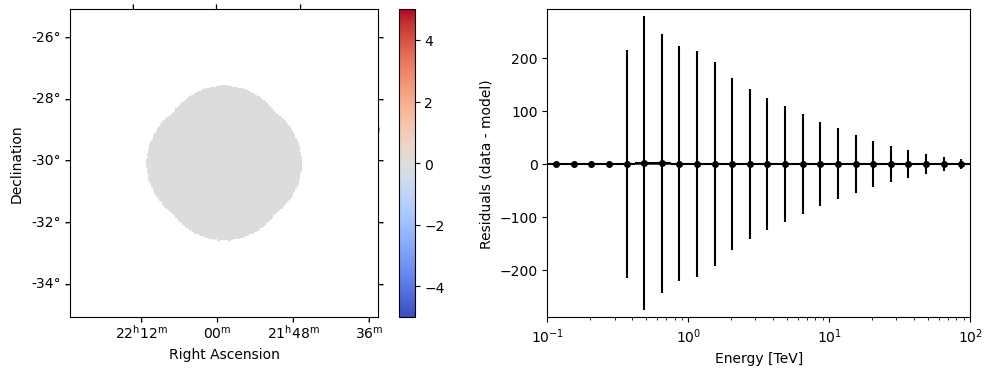

In [13]:
dataset_asimov_cl.plot_residuals()

In [14]:
ss = dataset_asimov_cl.stat_sum()
print(ss)

851228.6497772897


In [15]:
with dataset_asimov_cl.models.parameters.restore_status():
    dataset_asimov_cl.models.parameters['amplitude'].value = 0
    print(np.sqrt(dataset_asimov_cl.stat_sum()    -ss))

3.7394589516424364
